In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
train_static_well_dat=pd.read_csv('./ANTICLINE-main/wellbore_data_preproduction_well.csv')
test_static_well_dat=pd.read_csv('./ANTICLINE-main/wellbore_data_producer_wells.csv')

In [4]:
static_well_dat=pd.concat([train_static_well_dat,test_static_well_dat])

In [5]:
# add layer as a feature
static_well_dat['layer']=np.arange(static_well_dat.shape[0])%20

In [6]:
litho_keys = {'Shale':0,
                     'Shaly sandstone':1,
                     'Sandy shale': 2,
                     'Sandstone': 3}
static_well_dat['lith_id'] = static_well_dat['Rock facies'].map(litho_keys)


In [7]:
static_well_dat.tail(40)
N=np.unique(static_well_dat['Well_ID']).size
N_features=static_well_dat.shape[-1]

In [8]:
static_well_dat_per_well=(static_well_dat.values).reshape([N,-1,N_features])

In [9]:
lith=static_well_dat_per_well[:,:,-1]
lith=lith.astype(float)
myrange=7
N_lith=4
lith_variogram=np.zeros((N_lith-1,myrange))
bad=np.isnan(lith)
for trunc in range(N_lith-1):
    lith_ind=(lith<=trunc).astype(float)
    lith_ind[bad]=np.nan
    for i in np.arange(1,myrange):
        dif_lith=lith_ind[:,i:]-lith_ind[:,:-i]
        lith_variogram[trunc,i]=np.mean((dif_lith[np.isfinite(dif_lith)]**2/2).flatten())

Text(0, 0.5, 'Indicator Variogram')

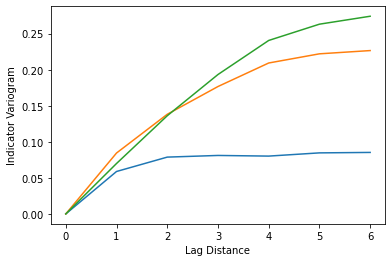

In [10]:
for i in range(N_lith-1):
    plt.plot(lith_variogram[i])
plt.xlabel('Lag Distance')
plt.ylabel('Indicator Variogram')

In [11]:
# cloud transform
static_well_dat.keys()

Index(['Well_ID', 'X, m', 'Y, m', 'Depth, m', 'Porosity, fraction',
       'Permeability, mD', 'Acoustic Impedance, kg*s/m^2', 'Rock facies',
       'Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa',
       'Shear velocity, m/s', 'Shear modulus, GPa', 'layer', 'lith_id'],
      dtype='object')

In [12]:
static_well_dat['Permeability, mD']=np.log(static_well_dat['Permeability, mD'])

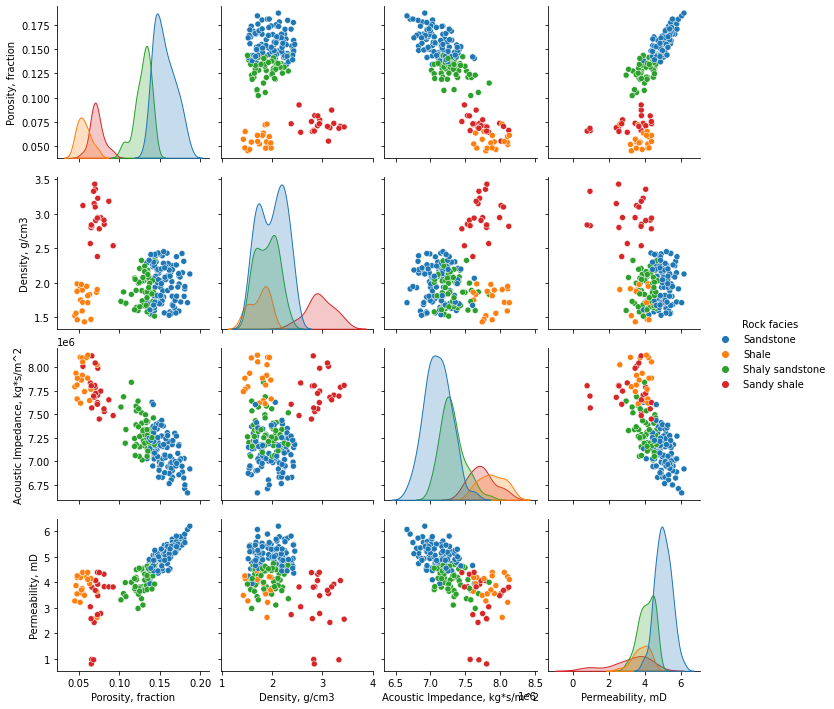

In [13]:
sns.pairplot(static_well_dat[['Porosity, fraction','Density, g/cm3','Rock facies','Acoustic Impedance, kg*s/m^2','Permeability, mD']].dropna(axis=0,how='any'), hue="Rock facies")


In [14]:
static_well_dat[['Porosity, fraction','Density, g/cm3','Rock facies']].dropna(axis=0,how='any')

,"Porosity, fraction","Density, g/cm3",Rock facies
1,0.09096,1.872982,Shaly sandstone
2,0.05878,3.187123,Sandy shale
4,0.12285,1.678339,Shaly sandstone
6,0.12519,1.977816,Shaly sandstone
8,0.13436,1.727151,Sandstone
...,...,...,...
1455,0.16289,2.092585,Sandstone
1456,0.15909,2.109057,Sandstone
1457,0.15692,1.620103,Sandstone
1458,0.15737,1.759469,Sandstone


In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train_dat=static_well_dat[['Porosity, fraction','Density, g/cm3','layer','lith_id']].values

imp_mean = IterativeImputer()
imp_mean.fit(train_dat)


In [17]:
train_dat_transform=imp_mean.transform(train_dat)

In [26]:
train_dat_transform[:,-1][train_dat_transform[:,-1]<0]=0
train_dat_transform[:,-1][train_dat_transform[:,-1]>3]=3
train_dat_transform[:,-1]=np.round(train_dat_transform[:,-1])

In [28]:
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
#scale
train_dat_norm=(train_dat_transform-np.min(train_dat_transform,axis=0))/(np.max(train_dat_transform,axis=0)-np.min(train_dat_transform,axis=0))

In [34]:
train_dat_norm.shape

(1660, 4)

In [36]:
train_dat_norm=train_dat_norm.reshape((-1,20,4))

In [38]:
train_dat_norm

(83, 20, 4)

In [41]:
prod_data=pd.read_csv('./ANTICLINE-main/production_history.csv')

In [44]:
prod_data.head(3)

,Well_ID,"Cumulative oil production (1 yr), MSTB","Cumulative oil production (2 yr), MSTB","Cumulative oil production (3 yr), MSTB","Cumulative Water production (1 yr), MSTB","Cumulative Water production (2 yr), MSTB","Cumulative Water production (3 yr), MSTB"
0,Well_no_1,450.98,684.20,847.33,494.89,1236.40,2108.7
1,Well_no_2,594.43,946.61,1201.20,226.97,646.50,1187.7
2,Well_no_3,381.75,611.38,781.40,393.17,948.18,1603.1


In [58]:
train_y=prod_data['Cumulative oil production (3 yr), MSTB'].values
train_y=(train_y-train_y.min()*0.7)/(train_y.max()*1.3-train_y.min()*0.7)

array([0.2070641 , 0.32294017, 0.18547507, 0.44475298, 0.10927002,
       0.14834836, 0.19938858, 0.15355487, 0.36000794, 0.09931215,
       0.24989833, 0.20481776, 0.16939381, 0.22338112, 0.05240439,
       0.12872405, 0.27739135, 0.1251941 , 0.19737474, 0.04321604,
       0.17582173, 0.45722897, 0.19721101, 0.19031156, 0.11915585,
       0.3634462 , 0.06851512, 0.32569078, 0.13343284, 0.32064799,
       0.3177664 , 0.19794778, 0.18505593, 0.09099155, 0.29703857,
       0.58883265, 0.10642117, 0.14020131, 0.51960892, 0.28917968,
       0.22541133, 0.22619067, 0.32395528, 0.47540265, 0.13197239,
       0.08354525, 0.30168842, 0.42078336, 0.03017028, 0.28826281,
       0.04922809, 0.19336343, 0.15210753, 0.62537649, 0.20319032,
       0.0963356 , 0.37012626, 0.37893477, 0.23806742, 0.19556064,
       0.75298523, 0.30486472, 0.3510357 , 0.16659736, 0.12517118,
       0.15952763, 0.16039866, 0.13813507, 0.36187442, 0.26429319,
       0.25659476, 0.1416421 , 0.17499655])

In [60]:
aa=layers.Input(shape=(20,4))
bb=layers.Flatten()(aa)
bb=layers.Dense(16,activation='relu')(bb)
bb=layers.Dense(16,activation='relu')(bb)
output=layers.Dense(1,activation='sigmoid')(bb)
model=tf.keras.Model(aa,output)
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [62]:
model.fit(train_dat_norm[:73,],train_y,epochs=100)

Train on 73 samples
Epoch 1/100
73/73 [==============================] - 0s 246us/sample - loss: 0.0149
Epoch 2/100
73/73 [==============================] - 0s 205us/sample - loss: 0.0147
Epoch 3/100
73/73 [==============================] - 0s 191us/sample - loss: 0.0140
Epoch 4/100
73/73 [==============================] - 0s 178us/sample - loss: 0.0141
Epoch 5/100
73/73 [==============================] - 0s 232us/sample - loss: 0.0136
Epoch 6/100
73/73 [==============================] - 0s 164us/sample - loss: 0.0136
Epoch 7/100
73/73 [==============================] - 0s 205us/sample - loss: 0.0127
Epoch 8/100
73/73 [==============================] - 0s 164us/sample - loss: 0.0125
Epoch 9/100
73/73 [==============================] - 0s 246us/sample - loss: 0.0124
Epoch 10/100
73/73 [==============================] - 0s 150us/sample - loss: 0.0127
Epoch 11/100
73/73 [==============================] - 0s 205us/sample - loss: 0.0113
Epoch 12/100
73/73 [==============================] - 

In [63]:
test_y=model.predict(train_dat_norm[73:,])

In [64]:
test_y#oil 3 year cumulative production forecast

array([[0.12528157],
       [0.1742774 ],
       [0.4066364 ],
       [0.15874493],
       [0.2882115 ],
       [0.12342048],
       [0.2848616 ],
       [0.07969328],
       [0.12085125],
       [0.3159287 ]], dtype=float32)